# InPoDa
*By Cyriac Thibaudault & Aymeric Goudout*

**InPoDa** récupère le contenu d'une landingzone de tweets (format *.json*) pour faire de la statistique.
C'est un code python basé sur les librairies suivantes:
- Pandas pour la gestion et la visualisation de données (inclus matplotlib)
- Textblob pour calculer (quand c'est possible) le sentiments d'une publication
- re pour appliquer différents regex
- random pour la selection du topic si celui-ci n'est pas mentionné dans la data

In [1]:
import pandas as pd
from textblob import TextBlob
import re, random

class InPoDa:
    def __init__(self, json_path, prompt:bool = True):
        df_tweets = pd.read_json(json_path)
        del df_tweets['_id'], df_tweets['public_metrics'], df_tweets['conversation_id'], df_tweets['geo'], df_tweets['lang'], df_tweets['created_at'], df_tweets['attachments']
        hashtags = []
        mentions = []
        urls = []
        for i in df_tweets['entities']:
            try:
                hashtags.append(list(dict.fromkeys([j['tag'] for j in i['hashtags']])))
            except:
                hashtags.append([])

            try:
                mentions.append([j['id'] for j in i['mentions']])
            except:
                mentions.append([])
    
            try:
                urls.append([j['url'] for j in i['urls']])
            except:
                urls.append([])

        cleaned_text = []
        for r,i in enumerate(df_tweets['text']):
            for j in urls[r]:
                i = i.replace(j,'')
            cleaned_text.append(re.sub(r'#\w+|@\w+|(\r\n|\r|\n)|[^a-zA-Zàâçéèêëîïôûùüæœ\d\s]','',i))

        topics = []
        for r,i in enumerate(df_tweets['context_annotations']):
            try:
                topics.append(list(dict.fromkeys([j['entity']['name'] for j in i])))
            except:
                try:
                    words = sorted(cleaned_text[r].split(),key=len,reverse=True)
                    topics.append([random.choice(words[:len(words)//3])])
                except:
                    topics.append([])

        sentiments = []
        for i in cleaned_text:
            sentiments.append(TextBlob(i).sentiment)

        df_tweets['hashtags'] = hashtags
        df_tweets['mentions'] = mentions
        df_tweets['urls'] = urls
        df_tweets['topics'] = topics
        df_tweets['cleaned_text'] = cleaned_text
        df_tweets['sentiments'] = sentiments
        del df_tweets['context_annotations'], df_tweets['entities']
        self.dataframe = df_tweets
        self.data = df_tweets.to_dict('records')
        
        # Fenêtre de dialogue #
        print(50*'*'+"\nInstance InPoDa initialisée avec succès\n"+50*'*'+'\n%d tweets détectés dans "'%len(self.data)+json_path+'"\n'+50*'*')
        if prompt:
            self._prompt()
    
    def _prompt(self):
        print(50*'*'+'\nCommandes disponibles:\n1>Top K User\n2>Top K Hashtags\n3>Top K Mentions\n4>Top K Topics\n5>Nombre de publications par user\n'+
                '6>Nombre de publications par Hashtag\n7>Nombre de publications par Topic\n8>Tweets of one User\n9>Tweets qui mentionnent un user\n'+
                '10>Users qui mentionnent un hashtag\n11>Users mentionnés par un User\n"">Quitter\n'+50*'*')
        ETAT = True
        while ETAT:
            prompt_input = input('Command:\n>>>')
            if prompt_input in ['1','2','3','4']:
                k = int(input('Choisir K\n>>>'))
                if prompt_input == '1':
                    self.top_k_users(k)
                elif prompt_input == '2':
                    self.top_k_hashtags(k)
                elif prompt_input == '3':
                    self.top_k_mentions(k)
                elif prompt_input == '4':
                    self.top_k_topics(k)
            elif prompt_input in ['5','6','7']:
                if prompt_input == '5':
                    self.nb_pubs_per_user()
                elif prompt_input == '6':
                    self.nb_pubs_per_hashtag()
                elif prompt_input == '7':
                    self.nb_pubs_per_topic()
            elif prompt_input in ['8','9','10','11']:
                r = input('Saisir ID ou Hashtag\n>>>')
                if prompt_input == '8':
                    print(self.tweets_of(int(r)))
                elif prompt_input == '9':
                    print(self.tweets_that_mention(int(r)))
                elif prompt_input == '10':
                    print(self.users_that_mention_hashtag(r))
                elif prompt_input == '11':
                    print(self.users_mentionned_by(int(r)))
            if input('Continue to use InPoDa ? (yes/no)') != 'yes':
                ETAT = False
        print(50*'*'+'\nPrompt instance ending\n'+50*'*')

    def _show(self, xy, title:str='Elements'):
        x, y = xy
        freq_series = pd.Series(y)
        fig = freq_series.plot(kind='bar')
        fig.set_title(title+' Frequency')
        fig.set_xlabel(title)
        fig.set_ylabel('Frequency')
        fig.set_xticklabels(x)
    
    def top_k_users(self,k:int):
        top = self.dataframe['author_id'].value_counts().iloc[0:k]
        self._show([list(top.index), list(top.values)])
    
    def _count_df_occ(self,arg:str,explore_list:bool):
        occ = {}
        for i in self.dataframe[arg]:
            if explore_list:
                for j in i:
                    if j in occ.keys():
                        occ[j] += 1
                    else:
                        occ[j] = 1
            else:
                if i in occ.keys():
                    occ[i] += 1
                else:
                    occ[i] = 1
        return occ
    
    def _top_k(self,arg:str,k:int,explore_list=True):
        l1, l2 = [], []
        dictionnaire = self._count_df_occ(arg, explore_list)
        for key in sorted(dictionnaire, key=dictionnaire.get, reverse=True):
            l1.append(key)
            l2.append(dictionnaire[key])
        return [l1[:k],l2[:k]]

    def top_k_hashtags(self,k:int):
        self._show(self._top_k('hashtags',k),'Hashtags')
    
    def top_k_mentions(self, k:int):
        self._show(self._top_k('mentions',k), 'Mentions')
    
    def top_k_topics(self, k:int):
        self._show(self._top_k('topics',k), 'Topics')
    
    def nb_pubs_per_user(self):
        self._show(self._top_k('author_id',len(self.data), False), 'Users')
    
    def nb_pubs_per_hashtag(self):
        self._show(self._top_k('hashtags',len(self.data)), 'Hashtags')
    
    def nb_pubs_per_topic(self):
        self._show(self._top_k('topics',len(self.data)), 'Topics')
    
    def tweets_of(self,user:int):
        output = []
        for tweet in self.data:
            if tweet['author_id'] == user:
                output.append(tweet)
        return output
    
    def tweets_that_mention(self,user:int):
        output = []
        user = str(user)
        for tweet in self.data:
            for m in tweet['mentions']:
                if m == user:
                    output.append(tweet)
        return output

    def users_that_mention_hashtag(self,tag:str):
        output = []
        for tweet in self.data:
            for t in tweet['hashtags']:
                if t == tag:
                    output.append(tweet['author_id'])
        return list(dict.fromkeys(output))
    
    def users_mentionned_by(self,user:int):
        output = []
        for tweet in self.data:
            if tweet['author_id'] == user:
                output = output + tweet['mentions']
        return list(dict.fromkeys(output))

## Exemple:
Ci-dessous le code de création d'une instance InPoDa. La classe InPoDa prend en argument le path d'un *.json* et la variable prompt (booléen par défaut sur **True**) qui indique à la classe si on veut l'utiliser en terminal ou non (par exemple dans un autre code).
Ensuite on importe avec **Panda** le *.json* sous forme de *dataframe* (accessible via self.dataframe) que l'on va simplifier de sorte à garder l'essentiel, c'est à dire:
- id
- author_id
- text
- hashtags
- mentions
- urls
- topics
- cleaned_text
- sentiments
### Execution d'un prompt
Après avoir généré une liste de dictionnaire (accessible via self.data) à partir du dataframe nouvellement créé un **prompt va se lancer ou non selon l'argument que vous avez emis en entrée** pour proposer à l'utilisateur de l'instance les fonctions suivantes : 
- 1 : Top K hashtags (k est un paramètre passé par l’utilisateur) -> Graph matplotlib
- 2 : Top K utilisateurs -> Graph matplotlib
- 3 : Top K utilisateurs mentionnés -> Graph matplotlib
- 4 : Top K topics -> Graph matplotlib
- 5 : Le nombre de publications par utilisateur -> Graph matplotlib
- 6 : Le nombre de publications par hashtag -> Graph matplotlib
- 7 : Le nombre de publications par topic -> Graph matplotlib
- 8 : L’ensemble de tweets d’un utilisateur spécifique -> Liste de Tweets
- 9 : L’ensemble de tweets mentionnant un utilisateur spécifique -> Liste de Tweets
- 10 : Les utilisateurs mentionnant un hashtag spécifique -> Liste d'Users
- 11 : Les utilisateurs mentionnés par un utilisateur spécifique -> Liste d'Users
- "" : Quitter le prompt

**************************************************
Instance InPoDa initialisée avec succès
**************************************************
20 tweets détectés dans "versailles_tweets_100.json"
**************************************************
**************************************************
Commandes disponibles:
1>Top K User
2>Top K Hashtags
3>Top K Mentions
4>Top K Topics
5>Nombre de publications par user
6>Nombre de publications par Hashtag
7>Nombre de publications par Topic
8>Tweets of one User
9>Tweets qui mentionnent un user
10>Users qui mentionnent un hashtag
11>Users mentionnés par un User
"">Quitter
**************************************************
**************************************************
Prompt instance ending
**************************************************


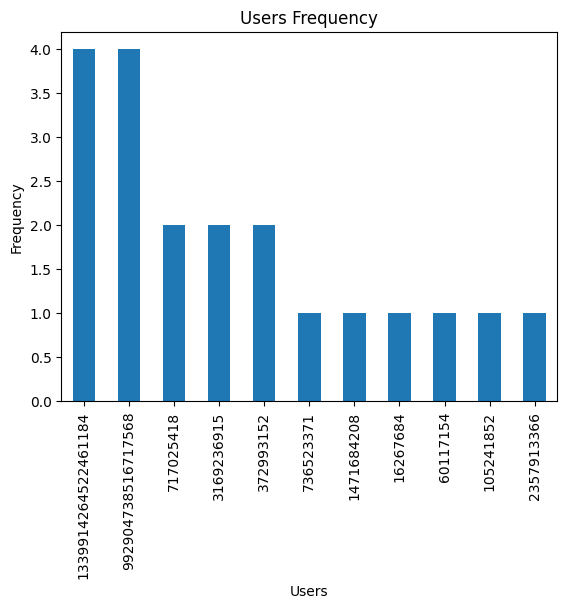

In [2]:
path = "versailles_tweets_100.json"
instance1 = InPoDa(path)

#instance1.top_k_users(3)
#instance1.top_k_hashtags(4)
#instance1.top_k_mentions(4)
#instance1.top_k_topics(3)
#instance1.nb_pubs_per_user()
#instance1.nb_pubs_per_hashtag()
#instance1.nb_pubs_per_topic()
#instance1.tweets_of(717025418)
#instance1.tweets_that_mention(19811019)
#instance1.users_that_mention_hashtag('CIV')
#instance1.users_mentionned_by(992904738516717568)